In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

from astropy.table import Table
import daft
import exoplanet as xo
import numpy as np
import pandas as pd
import pymc3 as pm
import pymc3_ext as pmx
import seaborn as sns
import theano.tensor as T
import scipy.stats as ss
import arviz as ar

sns.set_context('notebook')
sns.set_palette('colorblind')
sns.set_style('ticks')

Populating the interactive namespace from numpy and matplotlib


# Problem N1

Let us start solving the exercises $1-3$; as an introduction for $6$ and $7$ .

## Exercise 1:

Let us read the information from the table 1.

In [2]:
df = pd.read_csv("table1.txt", sep=' ')

xs = df['x'][4:19].to_numpy()
ys_obs = df['y'][4:19].to_numpy()
sigma_y = df['sigma_y'][4:19].to_numpy()

According to the equation (5), the best linear fit parameters $(m,b)$ for the data points $(x_i,y_i)$ are: 
$$\begin{bmatrix} m\\
b
\end{bmatrix}
=X=[A^TC^{-1}A]^{-1} [A^TC^{-1}Y]$$
where:

$$Y=\begin{bmatrix} y_1\\
y_2\\
\vdots\\
y_n
\end{bmatrix},
\hspace{1cm}
A=\begin{bmatrix} 1 & x_1\\
1 & x_2\\
\vdots & \vdots\\
1 & x_n
\end{bmatrix},  
\hspace{1cm} C=\begin{bmatrix} 
\sigma_{y1}^2 & 0 & \cdots & 0\\
0 & \sigma_{y2} & \cdots & 0\\
 &\cdots \\
 0 & 0 & \cdots & \sigma_{n1}^2
 \end{bmatrix}$$




In [3]:
Y = ys_obs
A = np.array([ones_like(xs), xs]).T
C = diag(sigma_y**2)

P = matmul(A.T, linalg.inv(C))
X1 = linalg.inv(matmul(P, A))
X2 = matmul(P, Y)
X = matmul(X1, X2)

xs_obs = linspace(0,300, 100)
ys_true = X[1]*xs_obs + X[0]

print(X)

[36.18781935  2.2326614 ]


(0.0, 700.0)

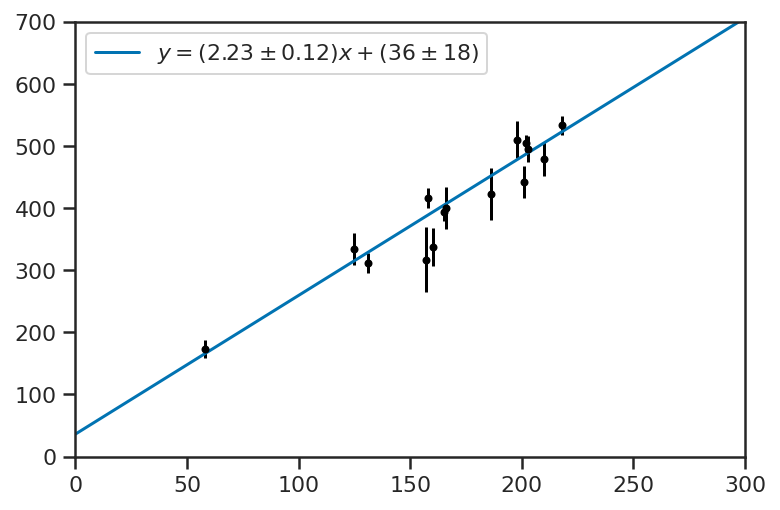

In [4]:
errorbar(xs, ys_obs, yerr=sigma_y, color='black', fmt='.')
plot(xs_obs, ys_true, label=r'$y=(2.23 \pm 0.12)x+(36 \pm 18)$')
legend()
xlim([0, 300])
ylim([0, 700])


From the definition made before, is important to remark that $[A^TC^{-1}A]^{-1}$ is the covariant matrix of the parameters in $X$. From here the, computed $\sigma_m^2$ is the $(2,2)$ element of the previous matrix

In [5]:
print(X1)

[[ 3.40072342e+02 -1.91379764e+00]
 [-1.91379764e+00  1.16988991e-02]]


From this Matrix we may compute the variance of $\sigma_m^2$ given by: `1.16988991e-02`

## Exercise 2:

Now, let us repeat the Exercise 1, but with all the data in the table.

In [6]:
xs = df['x'].to_numpy()
ys_obs = df['y'].to_numpy()
sigma_y = df['sigma_y'].to_numpy()

Y = ys_obs
A = np.array([ones_like(xs), xs]).T
C = diag(sigma_y**2)

P = matmul(A.T, linalg.inv(C))
X1 = linalg.inv(matmul(P, A))
X2 = matmul(P, Y)
X = matmul(X1, X2)

xs_obs = linspace(0,300, 100)
ys_true = X[1]*xs_obs + X[0]

print(X)
print(X1)

[213.27349198   1.07674752]
[[ 2.07188189e+02 -1.05427206e+00]
 [-1.05427206e+00  5.99181008e-03]]


(0.0, 700.0)

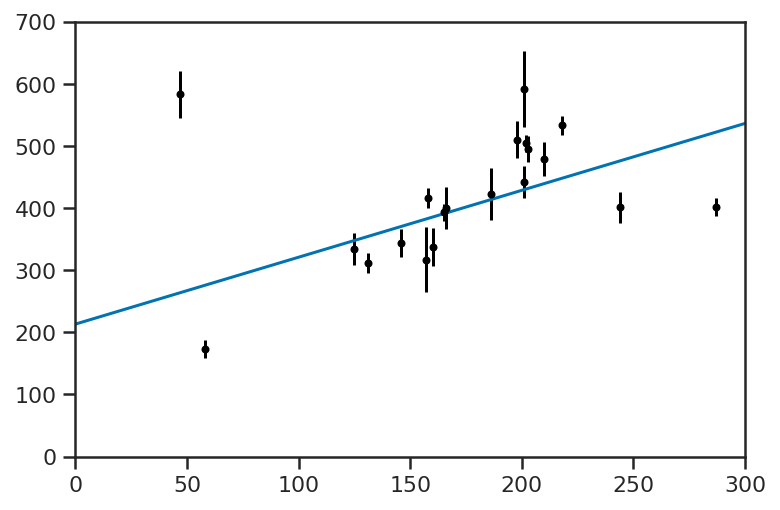

In [7]:
errorbar(xs, ys_obs, yerr=sigma_y, color='black', fmt='.')
plot(xs_obs, ys_true, label=r'$y=(1.08\pm0.08)x+(213\pm 14) $')
xlim([0, 300])
ylim([0, 700])

and the variance of $\sigma_m^2$: `5.99e-03`

There are two things, I don't like of this result:
1. The variance $\sigma_m^2$ has decreased after incorporating all the values in the table; however, all the points are are now more scattered. 
2. The value of $b$ changed dramatically after incorporating all the changes.

We can see comparing both plots, that the new points are quite far appart from the linear fit.

## Exercise 3:

Let us modify $A$, by introducing a column of values $x_i^2$, and another element in $X$, denoted by $q$.

In [8]:
df = pd.read_csv("table1.txt", sep=' ')

xs = df['x'][4:19].to_numpy()
ys_obs = df['y'][4:19].to_numpy()
sigma_y = df['sigma_y'][4:19].to_numpy()

In [9]:
Y = ys_obs
A = np.array([ones_like(xs), xs, xs**2]).T
C = diag(sigma_y**2)

P = matmul(A.T, linalg.inv(C))
X1 = linalg.inv(matmul(P, A))
X2 = matmul(P, Y)
X = matmul(X1, X2)

print(X)
print(X1)

[6.95557316e+01 1.67069125e+00 2.01465753e-03]
[[ 1.55388546e+03 -2.23563932e+01  7.32865068e-02]
 [-2.23563932e+01  3.55985601e-01 -1.23426449e-03]
 [ 7.32865068e-02 -1.23426449e-03  4.42482621e-06]]


(0.0, 700.0)

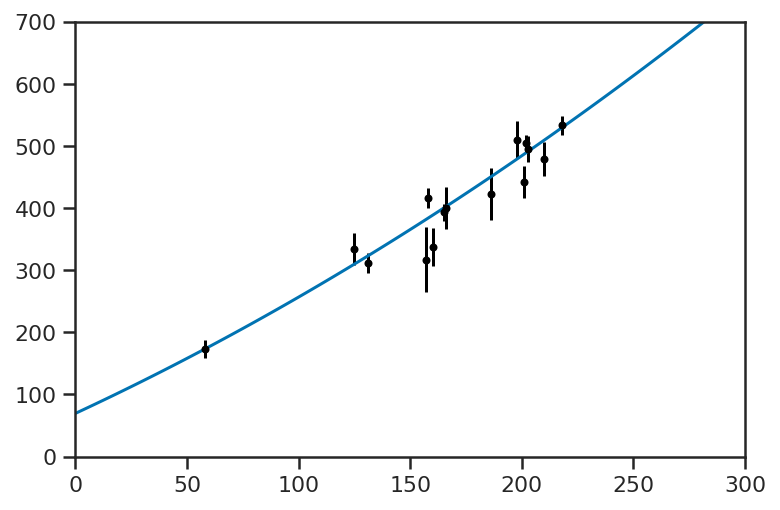

In [10]:
xs_obs = linspace(0, 300, 100)
ys_true = X[2]*xs_obs**2 + X[1]*xs_obs + X[0]

errorbar(xs, ys_obs, yerr=sigma_y, color='black', fmt='.')
plot(xs_obs, ys_true)
xlim([0, 300])
ylim([0, 700])

## Exercise 6

Let us start by storing the information of the Table 1 in appropiate working variables, and plotting them

Text(0, 0.5, '$y_\\mathrm{obs}$')

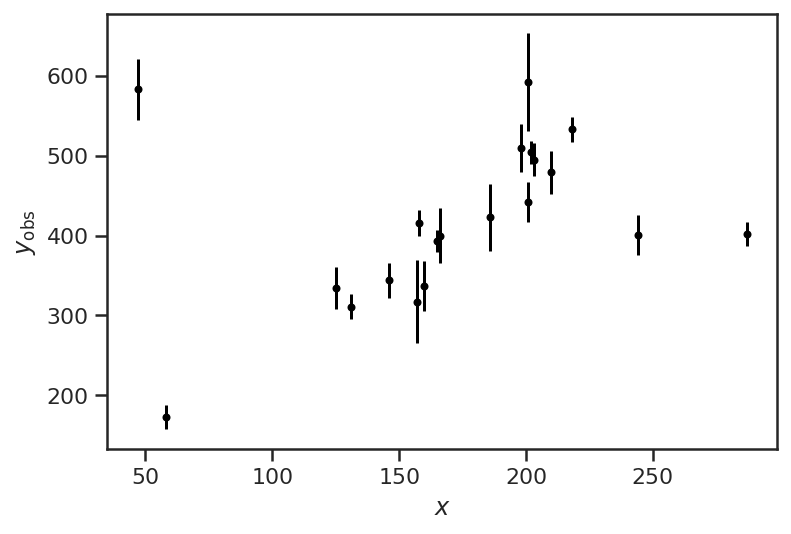

In [11]:
df = pd.read_csv("table1.txt", sep=' ')
xs = df['x'].to_numpy()
ys_obs = df['y'].to_numpy()
sigma_y = df['sigma_y'].to_numpy()

errorbar(xs, ys_obs, yerr=sigma_y, color='black', fmt='.')
xlabel(r'$x$')
ylabel(r'$y_\mathrm{obs}$')

In [12]:
with pm.Model() as mixture:

    m = pm.Normal('m', mu = 2, sigma = 2)
    b = pm.Normal('b', mu=100, sigma=200)

    Y_e = pm.Normal('Y_e', mu = 400, sigma = 200)
    V_e= pm.Lognormal('V_e', mu=log(200), sigma =log(200))

    P_bad = pm.Beta('P_bad', alpha=6, beta=14)

    ys_true = pm.Deterministic('ys_true', m*xs + b) 
    _ = pm.Mixture('ys_obs', [1-P_bad, P_bad],[pm.Normal.dist(mu=ys_true, sigma= sigma_y), pm.Normal.dist(mu=Y_e*ones_like(ys_obs), sigma=V_e)], observed=ys_obs)

<ipython-input-13-ef98339a6624>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  mix_trace = pm.sample(draws = 1000, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P_bad, V_e, Y_e, b, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


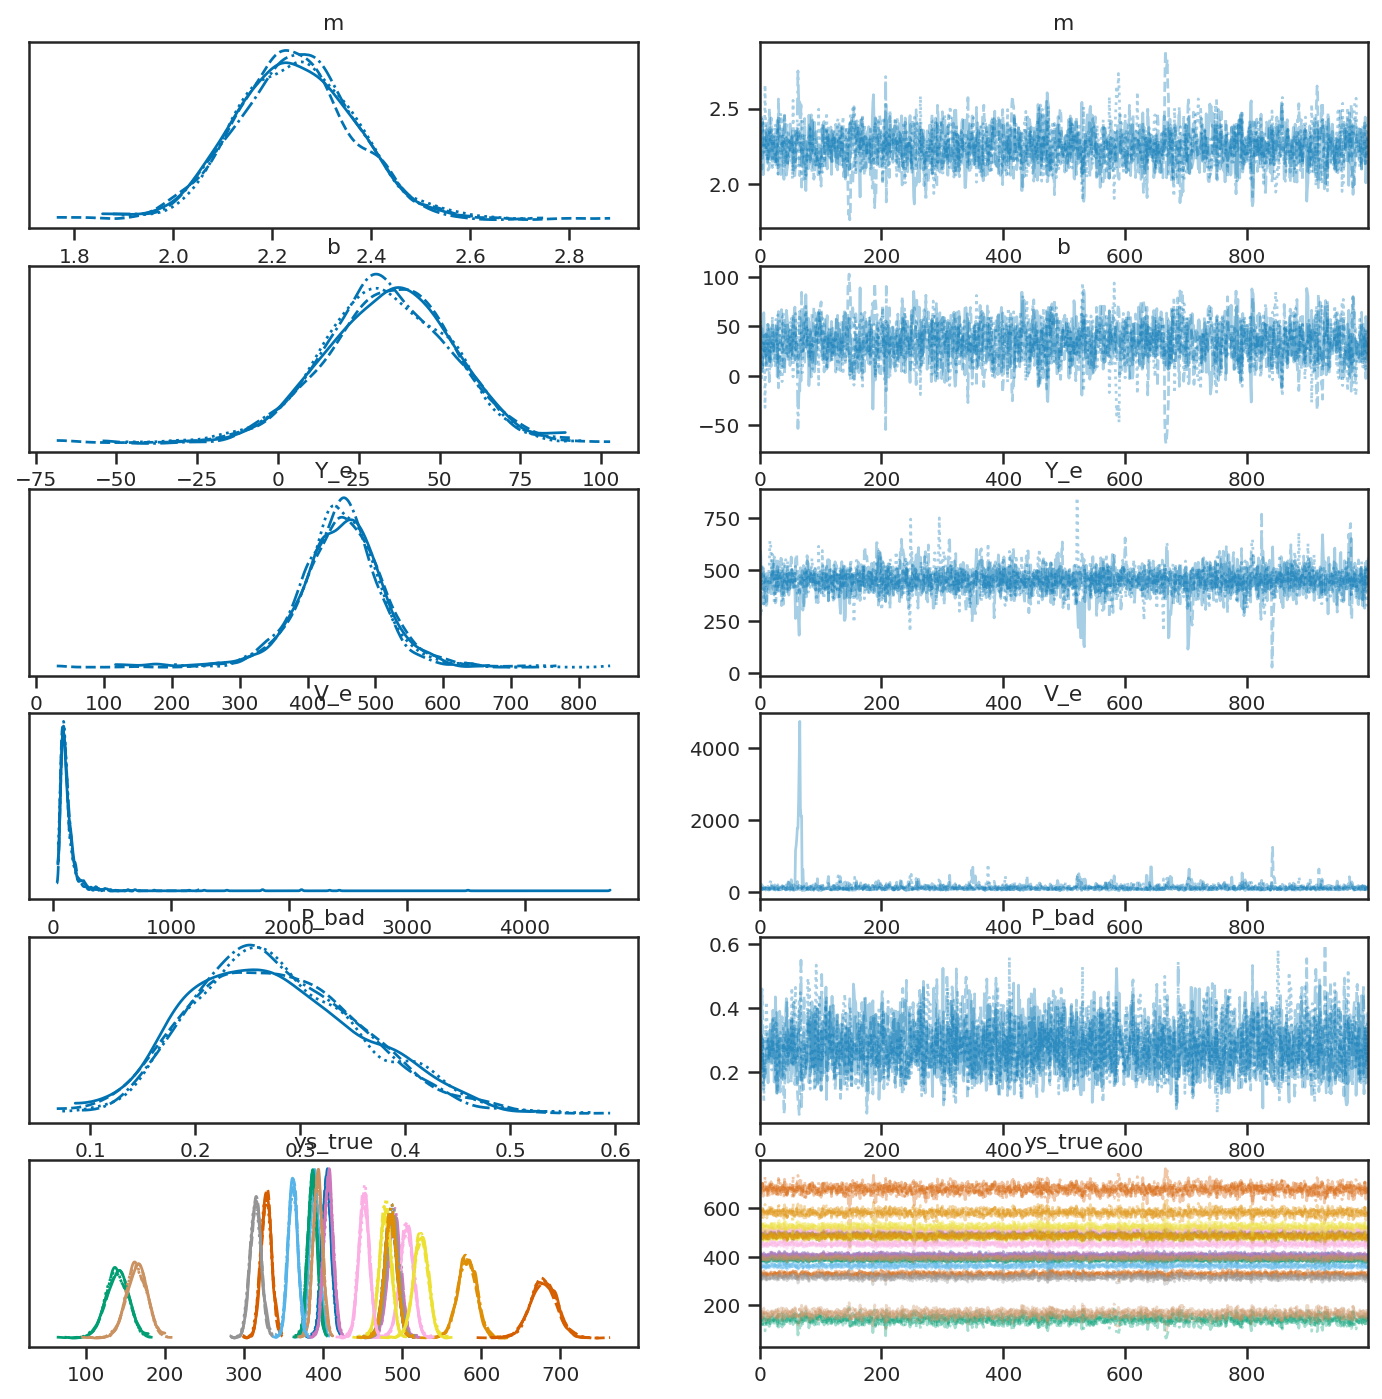

In [13]:
with mixture:
    mix_trace = pm.sample(draws = 1000, tune = 1000)
    ar.plot_trace(mix_trace)

Text(0.5, 1.0, 'Full posterior Distribution')

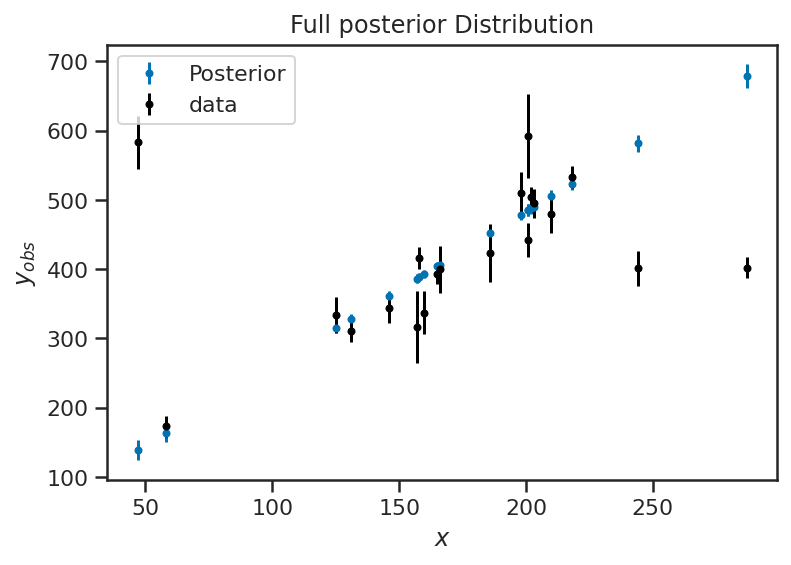

In [14]:
errorbar(xs, mean(mix_trace['ys_true'], axis=0), yerr=std(mix_trace['ys_true'], axis=0), fmt='.', label=r'Posterior')
errorbar(xs, ys_obs, yerr=sigma_y, color='black', fmt='.', label='data')
xlabel(r'$x$')
ylabel(r'$y_{obs}$')
legend(loc='best')
title(r'Full posterior Distribution')

From this plot, we can see a good estimate of the linear regression. However, is important to recall that we have plotted the full posterior without marginalizing over the $P_\mathrm{bad}$, $Y_e$ and $V_e$. Therefore, after marginalizing over $P_\mathrm{bad}$, $Y_e$ and $V_e$, we get the subspace $(b,m)$. Furthermore, using a kernel density estimator, we have drawn different contours to localize a zone of maximum density where the MAP is localized. 

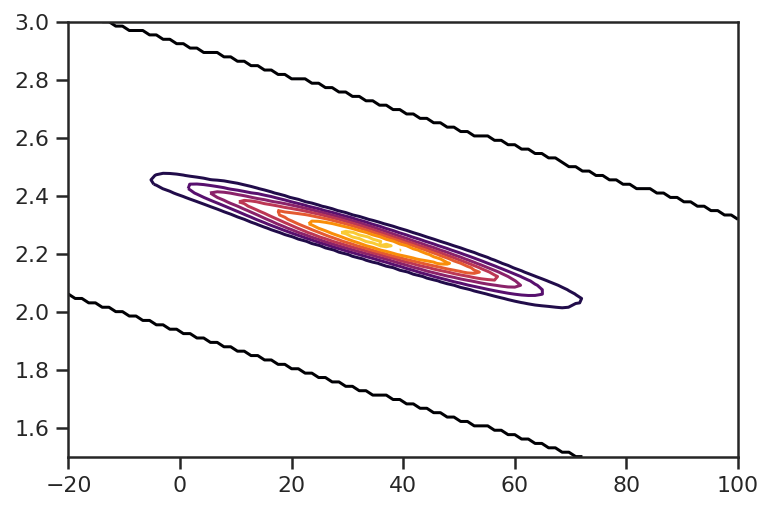

In [15]:
with mixture:
    bs, ms = mix_trace['b'], mix_trace['m']
    kde = ss.gaussian_kde(vstack((bs, ms)))

    b = linspace(-20, 100, 100)
    m = linspace(1.5, 3, 100)
    B, M = meshgrid(b, m, indexing='ij')
    density = kde(vstack((B.flatten(), M.flatten()))).reshape(M.shape)

    #pm.plot_pair(mix_trace, var_names=['b', 'm'])
    contour(B, M, density, cmap='inferno')

Finally, computing the MAP estimate and plotting samples from the neighboors:

32.121212121212125 2.257575757575758


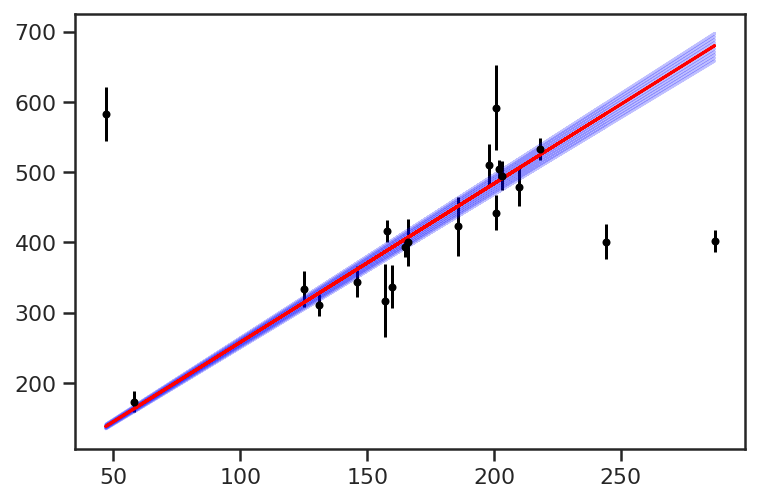

In [16]:
i_max = argmax(density) 
errorbar(xs, ys_obs, yerr=sigma_y, color='black', fmt='.', label='data')

for k in range(-5,5):
    if k != 0:
        plot(xs, M.ravel()[i_max+k]*xs + B.ravel()[i_max+k], color='blue', alpha=0.25)

plot(xs, M.ravel()[i_max]*xs + B.ravel()[i_max], color='red', alpha=1.0)

print(B.ravel()[i_max], M.ravel()[i_max])

The MAP line in comparison with fit defined in the exercise 2, is definitely a better fit.

## Exercise 7

Now we will provide the $P_\mathrm{bad}$ distribution from the fully marginalized posterior except $P_\mathrm{bad}$:

In [17]:
with pm.Model() as mixture2:

    m = pm.Normal('m', mu = 2, sigma = 2)
    b = pm.Normal('b', mu=100, sigma=200)

    Y_e = pm.Normal('Y_e', mu = 400, sigma = 200)
    V_e= pm.Lognormal('V_e', mu=log(200), sigma =log(200))

    P_bad = pm.Beta('P_bad', alpha=6, beta=14)

    ys_true = pm.Deterministic('ys_true', m*xs + b) 
    _ = pm.Mixture('ys_obs', [1-P_bad, P_bad],[pm.Normal.dist(mu=ys_true, sigma= sigma_y/2.0), pm.Normal.dist(mu=Y_e*ones_like(ys_obs), sigma=V_e)], observed=ys_obs)

In [18]:
with mixture2:
    mix_trace2 = pm.sample(draws = 1000, tune = 1000)

<ipython-input-18-0622f2313d7b>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  mix_trace2 = pm.sample(draws = 1000, tune = 1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P_bad, V_e, Y_e, b, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.5178403802048148, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


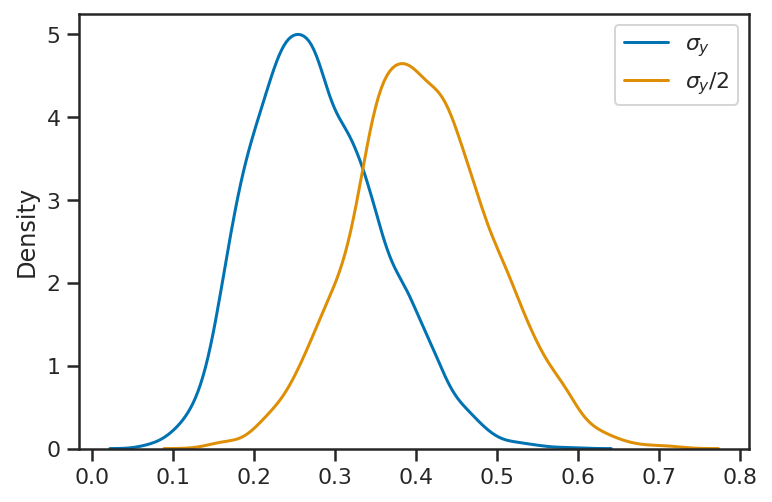

In [19]:
sns.kdeplot(mix_trace['P_bad'], label=r'$\sigma_y$')
sns.kdeplot(mix_trace2['P_bad'], label=r'$\sigma_y/2$')
legend()

# Problem N2

Let us start opening the data, which contains three important fields: `JD` which is the Julian Day Calendar time $t$ where the observations were taken, the `vr` field which measure $v_r$ and finally the measurements uncertainties in `sigma_vr`.

In [20]:
hd126614A_data = Table.read("HowardEtAl2010-HD126614A-apj319972t5_ascii.txt", format='ascii', header_start=3, data_start=4,
                            names=['JD', 'vr', 'sigma_vr', 'instrument'])
#hd126614A_data

ts = hd126614A_data['JD']/365.25
tmid = median(ts)

rv_obs = hd126614A_data['vr']
sigma_rv = hd126614A_data['sigma_vr']


In [21]:
def plot_data(rv, sigma_rv=None, P=None, **kwargs):

    ts = hd126614A_data['JD']/365.25
    tmid = median(ts)

    if P is None:
        ts = ts - tmid
        xlabel(r'$t - t_\mathrm{ref} / \mathrm{mid}$')
    else:
        ts = (ts - tmid) % P
        xlabel(r'$ \left( t - t_\mathrm{mid} \right) \, \mathrm{mod} \, P / \mathrm{yr}$')
        
    if sigma_rv is None:
        scatter(ts, rv, **kwargs)
    else:
        errorbar(ts, rv, yerr=sigma_rv, fmt='.', **kwargs)

    ylabel(r'$v_r / \mathrm{m} \, \mathrm{s}^{-1}$')

Now, we want to to plot the data with its uncertainty, over the whole time domain:

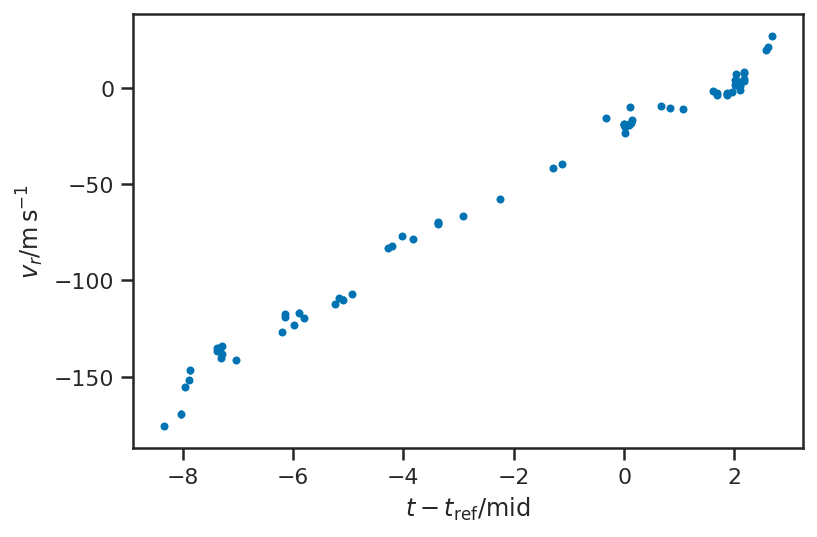

In [22]:
P_orb = 1253.5/365.25
sigma_P_orb = 17.0/365.25
plot_data(rv_obs, sigma_rv)

From here, we can see a strong linear dependence between the measured radial velocity and the observation time. In order to determine the Keplerian orbit, we will create a model with two important parts. The first one is the linear trend composed by two parameters $m$ and $b$ on which we construct our linear trend priors.

The second part of the model constructs the orbit, substracting the linear trend, but keeping the original data under the construction of the likelyhood function. We will proceed as we did in class following the keplerian model discussion inFulton et.al. [2018]. Is important to stress that in class, we have used the choice of $P$, $T_c$, $\sqrt{e}\cos\omega$, $\sqrt{e}\sin \omega$, and $K$ as the base of our priors; which favours observations when $K$ and $P$ are large in comparison to the observational baseline.

In [23]:
ts = hd126614A_data['JD']/365.25
tmid = median(ts)

with pm.Model() as trend:

    #Define the local Keplerian Model
    K = pm.Lognormal('K', mu=log(7.3), sigma=1.0)

    dP = pm.Normal('dP', mu=0, sigma=1)
    P = pm.Deterministic('P', P_orb + sigma_P_orb*dP)

    A = pmx.UnitDisk('A', testval=[0.01, 0.01])

    e = pm.Deterministic('e', T.sqrt(A[0]*A[0]+A[1]*A[1]))
    omega = pm.Deterministic('omega', T.arctan2(A[1], A[0]))

    t0_frac = pm.Uniform('t0_frac', 0, 1, testval=0.5)
    t0 = pm.Deterministic('t0', tmid + P*t0_frac)

    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=e, omega=omega)
    rv_orbit = pm.Deterministic('rv_orbit', orbit.get_radial_velocity(ts, K=K))

    #Now we define the linear model
    m = pm.Normal('m', mu = 16, sigma = 0.5)
    b = pm.Normal('b', mu = -23, sigma = 1)
    rv_linear = pm.Deterministic('rv_linear', m*(ts-tmid) + b)

    #Define the sum between the two models
    rv = pm.Deterministic('rv', rv_linear + rv_orbit)

    #Define the Likelyhood function
    _ = pm.Normal('rv_obs', mu = rv, sigma=sigma_rv, observed=rv_obs)


In [24]:
with trend:
    best_rv1 = pmx.optimize(vars=[m,b])
    best_rv2 = pmx.optimize(best_rv1, vars=[m,b,dP])
    best_rv3 = pmx.optimize(best_rv2, vars=[m, b, dP, t0_frac])
    best_rv4 = pmx.optimize(best_rv3, vars=[m, b, dP, t0_frac, A])
    best_rv5 = pmx.optimize(best_rv4, vars=[m, b, dP, t0_frac, A, K])

optimizing logp for variables: [b, m]


message: Optimization terminated successfully.
logp: -1397.104201199623 -> -1347.8931221602888
optimizing logp for variables: [dP, b, m]


message: Optimization terminated successfully.
logp: -1347.8931221602888 -> -1195.1634202618834
optimizing logp for variables: [t0_frac, dP, b, m]


message: Optimization terminated successfully.
logp: -1195.1634202618834 -> -474.5478777427099
optimizing logp for variables: [A, t0_frac, dP, b, m]


message: Optimization terminated successfully.
logp: -474.5478777427099 -> -367.934527557587
optimizing logp for variables: [K, A, t0_frac, dP, b, m]


message: Optimization terminated successfully.
logp: -367.934527557587 -> -367.6745807972993


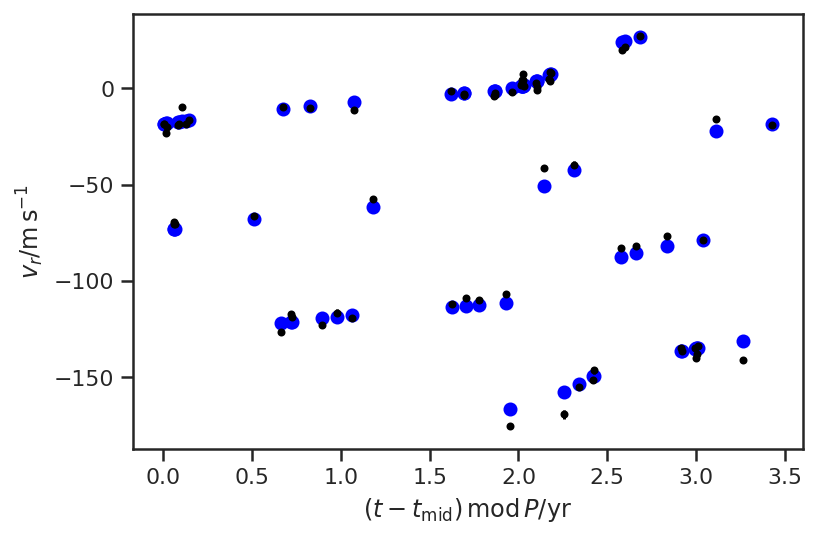

In [25]:
plot_data(rv_obs, sigma_rv, P=P_orb, color='black')
plot_data(best_rv5['rv'], P=P_orb, color='blue')

/home/sander/anaconda3/envs/phy688/lib/python3.9/site-packages/pymc3_ext/sampling/sampling.py:97: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, m, t0_frac, A, dP, K]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


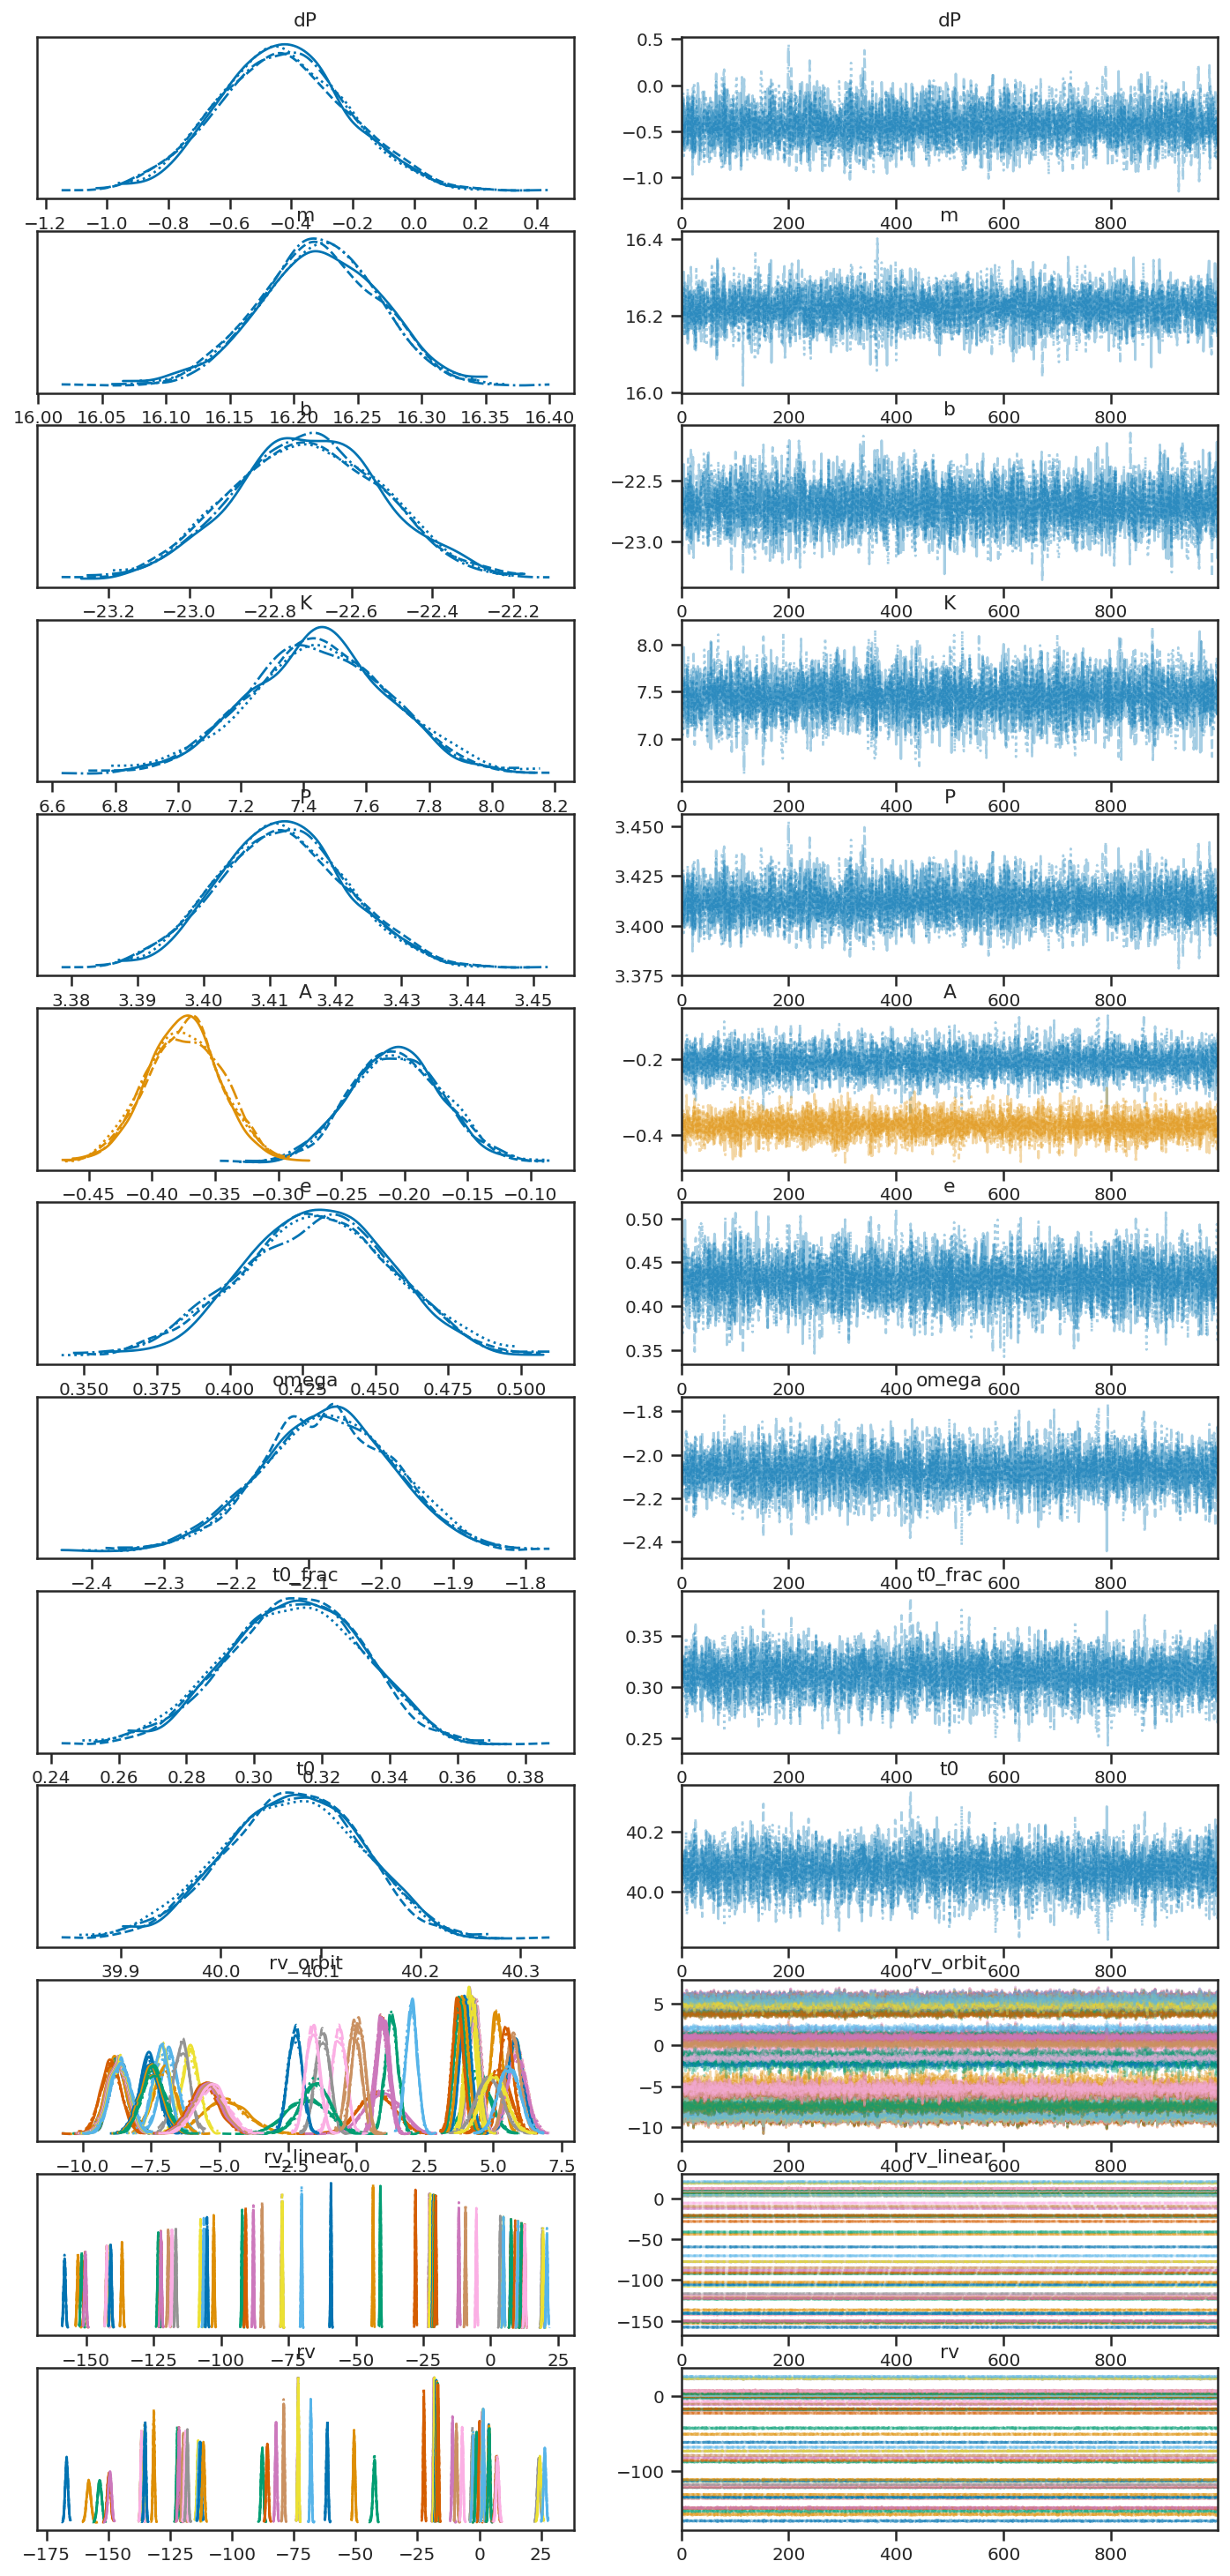

In [26]:
with trend:
    trend_trace = pmx.sample(start=best_rv5, draws = 1000, tune = 1000)
    ar.plot_trace(trend_trace)

Plotting the posterior we can see an impressive match between the model and the experimental data.

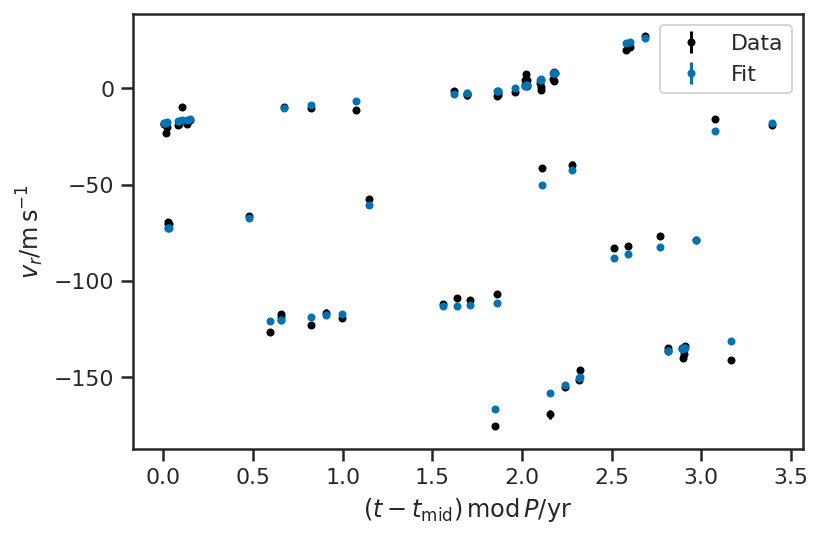

In [27]:
N = trend_trace['P'].shape[0]
i = randint(0, N)
P = trend_trace['P'][i]
plot_data(rv_obs, sigma_rv, P=P, color='black', label='Data')
plot_data(trend_trace['rv'][i,:], std(trend_trace['rv'], axis =0), P = P, label='Fit')
legend(loc='best')

Now, we we want to extract the set of variables that better fit the parameters, $m$, $b$, $P$, $t_0$, $\omega$, $e$, and $K$. 

m = 16.2201^{+0.0465}_{-0.0458}


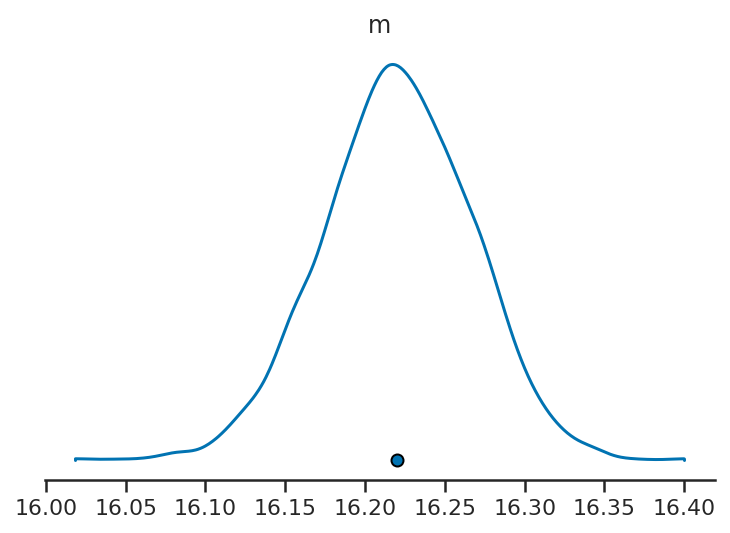

In [28]:
with trend:
    pm.plot_density(trend_trace, var_names=['m'], hdi_prob=1)
    m, l, h = quantile(trend_trace['m'], [0.5, 0.16, 0.84])
    print('m = {:.4f}^{{+{:.4f}}}_{{-{:.4f}}}'.format(m, h-m, m-l))


b = -22.7063^{+0.1874}_{-0.1850}


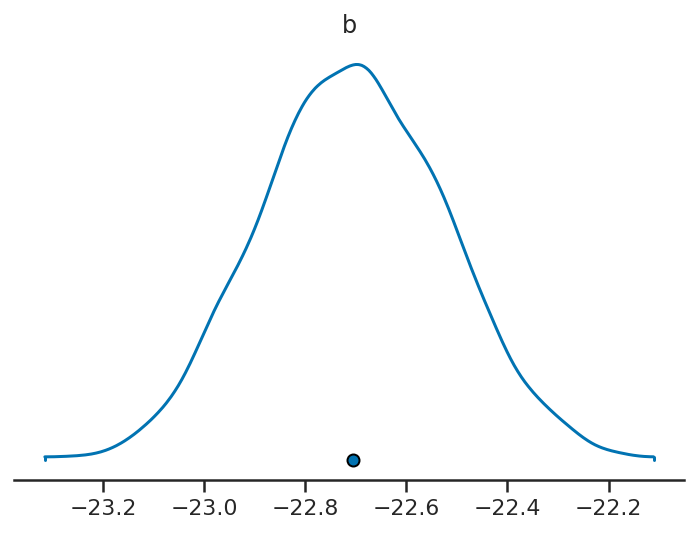

In [29]:
with trend:
    pm.plot_density(trend_trace, var_names=['b'], hdi_prob=1)
    m, l, h = quantile(trend_trace['b'], [0.5, 0.16, 0.84])
    print('b = {:.4f}^{{+{:.4f}}}_{{-{:.4f}}}'.format(m, h-m, m-l))

P = 3.4117^{+0.0100}_{-0.0095}


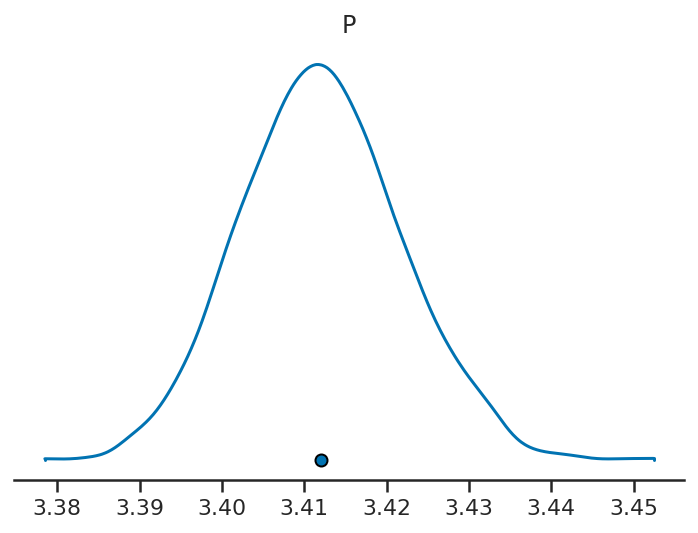

In [30]:
with trend:
    pm.plot_density(trend_trace, var_names=['P'], hdi_prob=1)
    m, l, h = quantile(trend_trace['P'], [0.5, 0.16, 0.84])
    print('P = {:.4f}^{{+{:.4f}}}_{{-{:.4f}}}'.format(m, h-m, m-l))

t0 = 40.0736^{+0.0666}_{-0.0706}


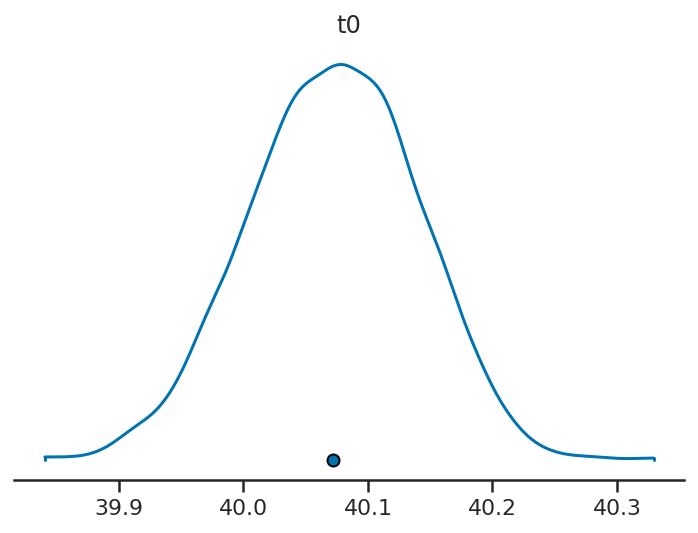

In [31]:
with trend:
    pm.plot_density(trend_trace, var_names=['t0'], hdi_prob=1)
    m, l, h = quantile(trend_trace['t0'], [0.5, 0.16, 0.84])
    print('t0 = {:.4f}^{{+{:.4f}}}_{{-{:.4f}}}'.format(m, h-m, m-l))


K = 7.4462^{+0.2239}_{-0.2239}


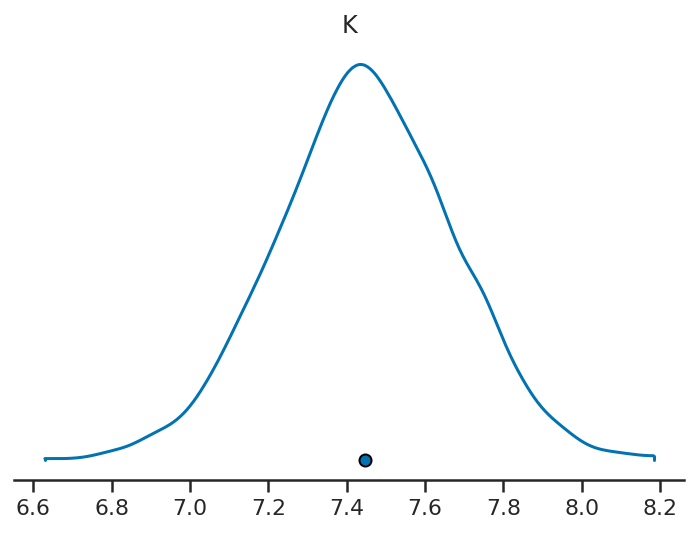

In [32]:
with trend:
    pm.plot_density(trend_trace, var_names=['K'], hdi_prob=1)
    m, l, h = quantile(trend_trace['K'], [0.5, 0.16, 0.84])
    print('K = {:.4f}^{{+{:.4f}}}_{{-{:.4f}}}'.format(m, h-m, m-l))

e = 0.4303^{+0.0256}_{-0.0265}


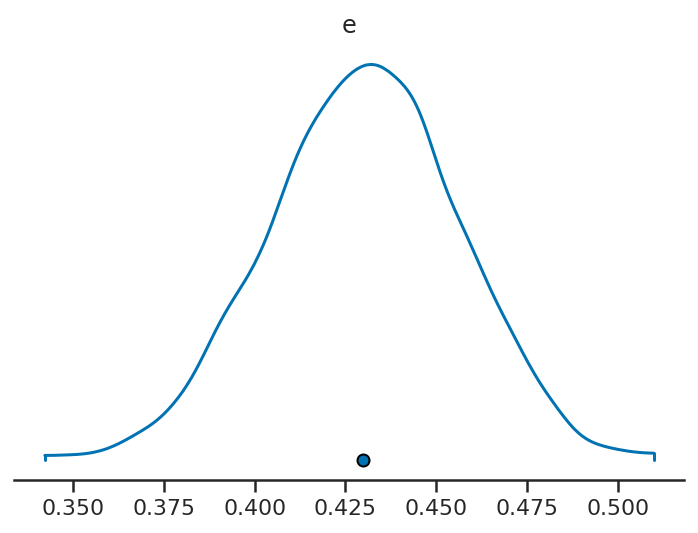

In [33]:
with trend:
    pm.plot_density(trend_trace, var_names=['e'], hdi_prob=1)
    m, l, h = quantile(trend_trace['e'], [0.5, 0.16, 0.84])
    print('e = {:.4f}^{{+{:.4f}}}_{{-{:.4f}}}'.format(m, h-m, m-l))

omega = -2.0735^{+0.0902}_{-0.0911}


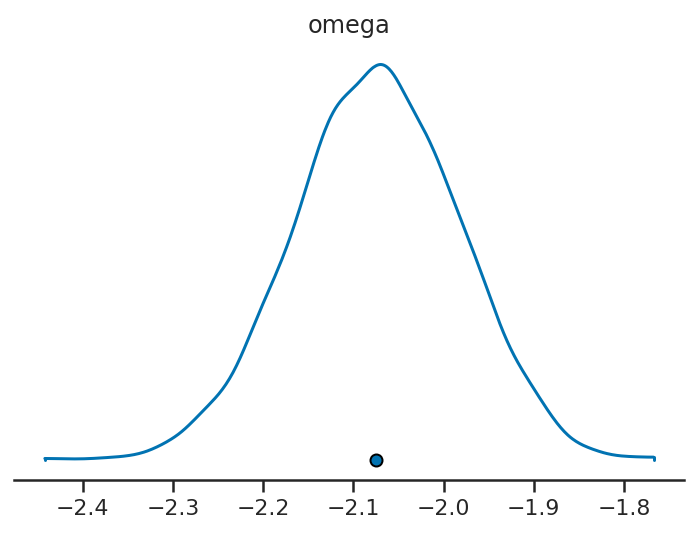

In [34]:
with trend:
    pm.plot_density(trend_trace, var_names=['omega'], hdi_prob=1)
    m, l, h = quantile(trend_trace['omega'], [0.5, 0.16, 0.84])
    print('omega = {:.4f}^{{+{:.4f}}}_{{-{:.4f}}}'.format(m, h-m, m-l))

We can see that the parameters fit exactly is was pointed out in the observations by Howard et.al 2010. However, from our analysis we can predict also the size of $T_c$. When a linear trend goes along with a Keplerian orbit, it means that instead a unique planet, a binary companion may be present, for example an star or another massive planet could be responsable for this behaviour. Finally we can plot our measurements residue compared to their measured uncertainty, folded in one period:

<Figure size 432x288 with 0 Axes>

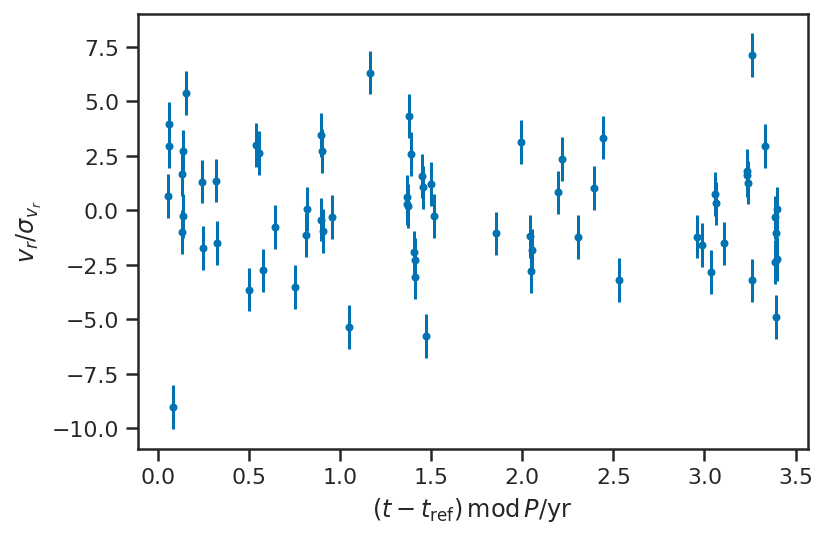

<Figure size 432x288 with 0 Axes>

In [35]:
def plot_residuals(rv, P=None, normalize=True, **kwargs):
    if P is None:
        ts = (hd126614A_data['JD'] - tmid)/(365.25)
        xlabel(r'$t - t_\mathrm{ref} / \mathrm{yr}$')
    else:
        ts = (hd126614A_data['JD'] - tmid)/(365.25) % P
        xlabel(r'$ \left( t - t_\mathrm{ref} \right) \, \mathrm{mod} \, P / \mathrm{yr}$')

    r = rv - hd126614A_data['vr']
    if normalize:
        r = r / hd126614A_data['sigma_vr']
        sigma_r = ones_like(r)
    else:
        sigma_r = hd126614A_data['sigma_vr']
        
    fmt = kwargs.pop('fmt', '.')
    errorbar(ts, r, yerr=sigma_r, fmt=fmt, **kwargs)

plot_residuals(mean(trend_trace['rv'], axis=0), P = mean(trend_trace['P']))
ylabel(r'$v_r / \sigma_{v_r}$')
figure()
#plot_residuals(mean(trend_trace['rv'], axis=0))
#ylabel(r'$v_r / \sigma_{v_r}$')
#figure()
#plot_residuals(mean(trend_trace['rv'], axis=0), normalize=False)
#ylabel(r'$v_r / \mathrm{km} \, \mathrm{s}^{-1}$')

The distribution of the residue around the origin are depicted as follows:

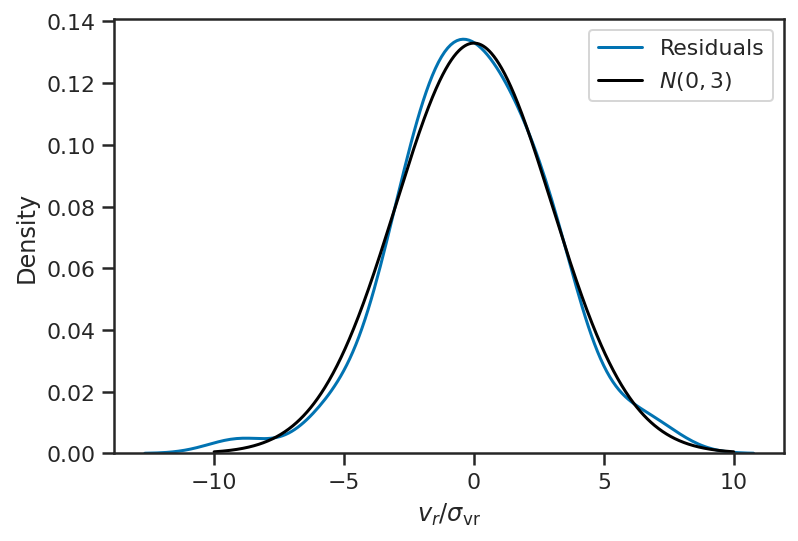

In [36]:
sns.kdeplot((mean(trend_trace['rv'], axis=0) - hd126614A_data['vr'])/hd126614A_data['sigma_vr'], label='Residuals')
xlabel(r'$v_r /\sigma_\mathrm{vr}$')
xs = linspace(-10, 10, 1024)
sigma = 3
plot(xs, 1/sqrt(2*pi*sigma**2)*exp(-0.5*xs*xs/sigma**2), color='black', label='$N(0,3)$')
legend(loc='best')

When the residuals oscillate around zero it implies that we have assumed an appropiate posterior for our data fit. However the width of these oscillations imply how far we are from tunning the priors to fit an appropiate model or the lack of assumptions inside our model. In our example, our model is $\sim 3$ sigma deviations away from the real observations.

Is also very important to stress, that if we miss some information, important effects may be going on without notice. For example, in our model,instead of one planet, two different planets are present on which the detectors may not have enough resolution to scope them as two different ones.

# Problem 3

Now we will choose our own planet from the IPAC catalog. We will choose the planet __6 Lyn b__ described in Sato et al. 2008. 

In [37]:
sato_data = Table.read('6_Lyn_Sato_2008.tbl.txt', format='ascii')
sato_data

<Table length=30>
     JD      Radial_Velocity Radial_Velocity_Uncertainty
    days          m / s                 m / s           
  float64        float64               float64          
------------ --------------- ---------------------------
2453028.2002             0.2                         5.0
 2453107.965             9.8                         4.7
2453290.2429            52.4                         7.5
2453307.1619            37.2                         4.5
 2453363.324            29.1                         6.1
 2453448.039           -15.3                         6.3
2453467.9581           -15.9                         9.8
2453494.9817            -0.8                        10.3
2453659.2879           -27.4                         5.7
         ...             ...                         ...
2454196.0062            19.2                         7.9
2454215.9689            41.8                         6.3
2454338.3163            -3.3                         6.5
2454379.2591             5.9                         5.6
2454416.1067            -4.0                         7.0
2454458.1686           -18.3                         7.1
2454492.1646           -42.8                         5.6
2454524.0101           -24.9                         9.9
2454553.9338           -32.8                         5.2
 2454556.984           -40.8                         5.3

The period and its uncertainty is:

In [38]:
rv_obs = sato_data['Radial_Velocity']
sigma_rv = sato_data['Radial_Velocity_Uncertainty']

ts = sato_data['JD']/365.25
P_orb = 899/365.25
sigma_P_orb = 19/365.25
tmid = median(ts)

As we did before, we define the `plot_data()` function as follows:

In [39]:
def plot_data(rv, sigma_rv=None, P=None, **kwargs):

    ts = sato_data['JD']/365.25
    tmid = median(ts)

    if P is None:
        ts = ts - tmid
        xlabel(r'$t - t_\mathrm{ref} / \mathrm{mid}$')
    else:
        ts = (ts - tmid) % P
        xlabel(r'$ \left( t - t_\mathrm{mid} \right) \, \mathrm{mod} \, P / \mathrm{yr}$')
        
    if sigma_rv is None:
        scatter(ts, rv, **kwargs)
    else:
        errorbar(ts, rv, yerr=sigma_rv, fmt='.', **kwargs)

    ylabel(r'$v_r / \mathrm{m} \, \mathrm{s}^{-1}$')


From here, we can plot the radial velocity in terms of time by folding the period.

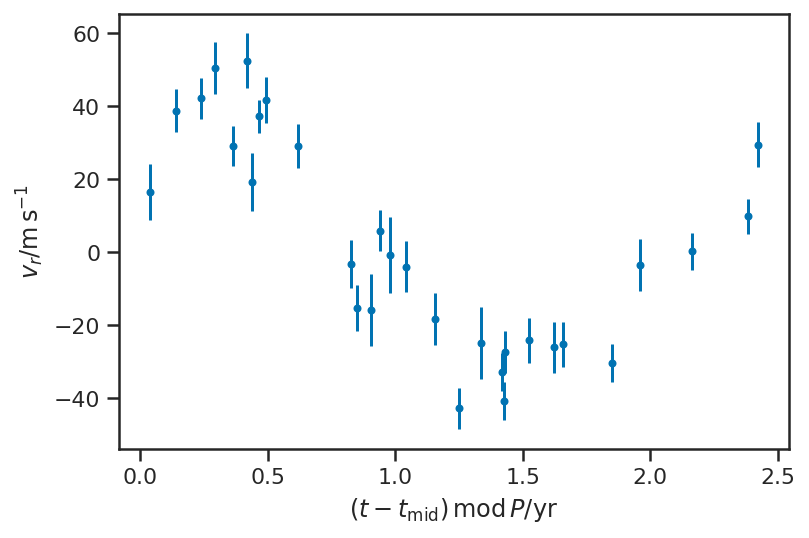

In [40]:
plot_data(rv_obs, sigma_rv, P = P_orb)

According to the data representation of the folded measurements across the period, we can construct a model and adjust it to the best fit, using the MCMC techniques.

In [53]:
ts = sato_data['JD']/365.25
tmid = median(ts)

with pm.Model() as planet:

    dP = pm.Normal('dP', mu = 0, sigma = 1) 
    P = pm.Deterministic('P', P_orb + dP*sigma_P_orb)

    K = pm.Lognormal('K', mu=log(36), sigma = 2)
    A = pmx.UnitDisk('A', testval=[0.01, 0.01])
    e = pm.Deterministic('e', T.sqrt(A[0]*A[0]+A[1]*A[1]))
    omega = pm.Deterministic('omega', T.arctan2(A[1], A[0]))

    t0_frac = pm.Uniform('t0_frac', 0, 1, testval=0.5)
    t0 = pm.Deterministic('t0', tmid+P*t0_frac)

    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=e, omega=omega)
    
    rv = pm.Deterministic('rv', orbit.get_radial_velocity(ts, K=K))
    
    _ = pm.Normal('rv_obs', mu=rv, sigma=sato_data['Radial_Velocity_Uncertainty'], observed=sato_data['Radial_Velocity'])

Now we have to optimize the best starting value scenario to start rolling out the ball in the MCMC settings.

In [54]:
with planet:
    best_rv = pmx.optimize(vars=[t0])
    best_rv1 = pmx.optimize(start=best_rv, vars=[t0, dP, P])
    best_rv2 = pmx.optimize(start=best_rv1, vars=[t0, dP, P, A, K])


optimizing logp for variables: [dP, t0_frac]


message: Optimization terminated successfully.
logp: -283.55632499166865 -> -123.7583508137717
optimizing logp for variables: [dP, t0_frac]


message: Optimization terminated successfully.
logp: -123.7583508137717 -> -123.7583508137717
optimizing logp for variables: [K, A, dP, t0_frac]


message: Desired error not necessarily achieved due to precision loss.
logp: -123.7583508137717 -> -119.74969099760092


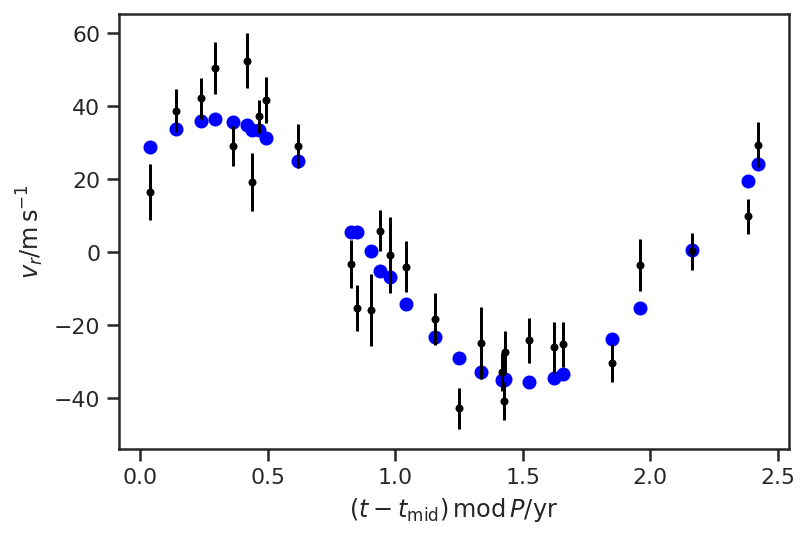

In [55]:
plot_data(rv_obs, sigma_rv, P=P_orb, color='black')
plot_data(best_rv['rv'], P=P_orb, color='blue')

/home/sander/anaconda3/envs/phy688/lib/python3.9/site-packages/pymc3_ext/sampling/sampling.py:97: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t0_frac, A, K, dP]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


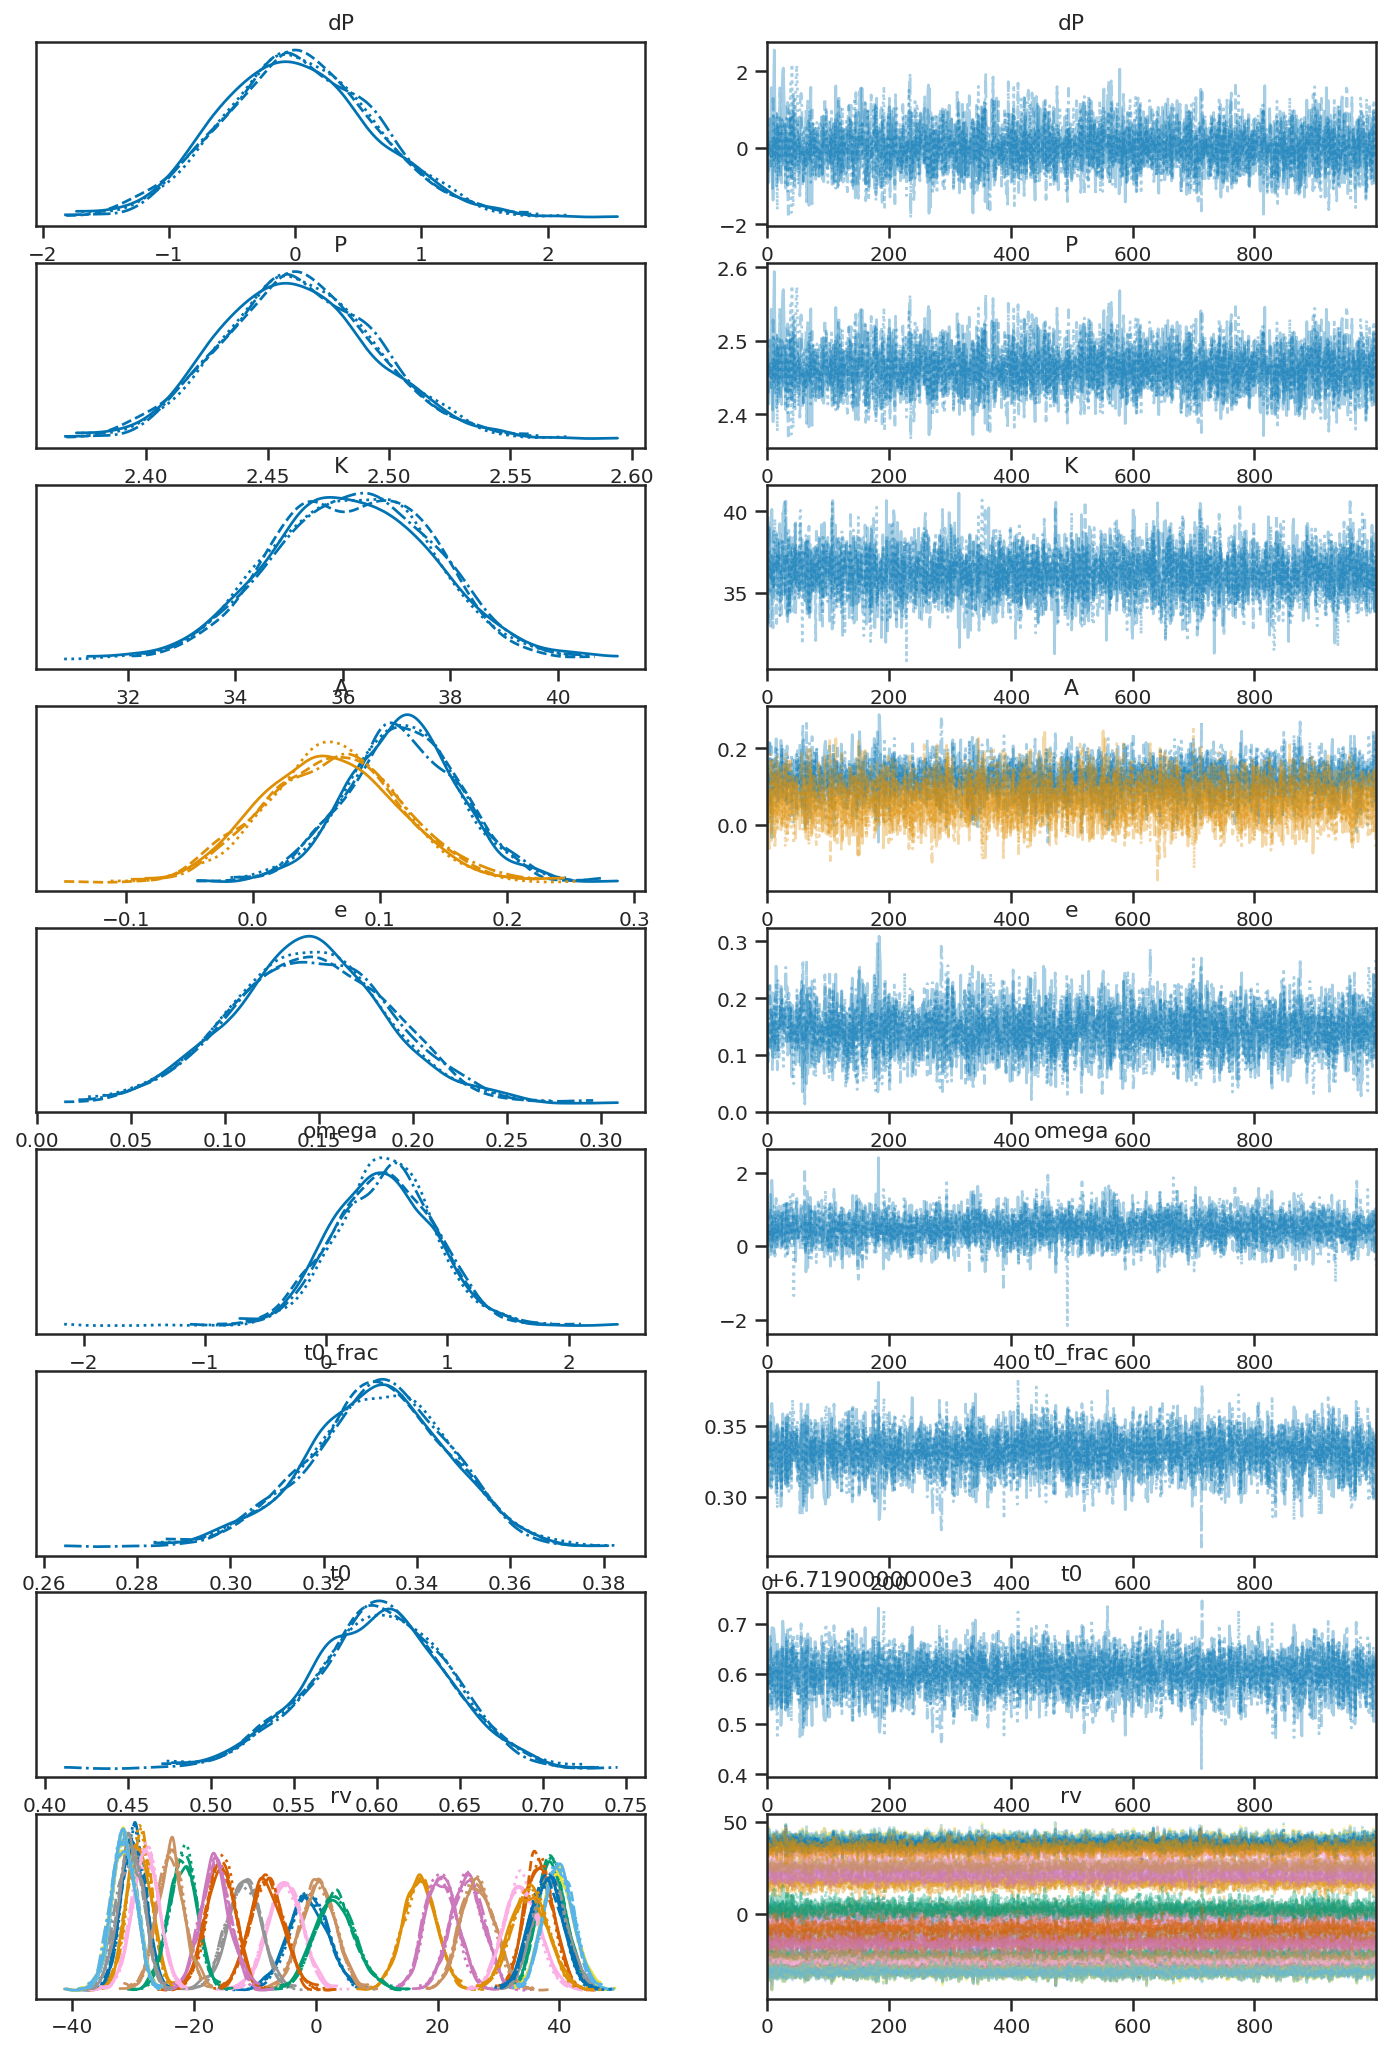

In [57]:
with planet:
   planet_trace = pmx.sample(start=best_rv2, draws=1000, tune=1000)
   ar.plot_trace(planet_trace)

Plotting the posterior distribution:

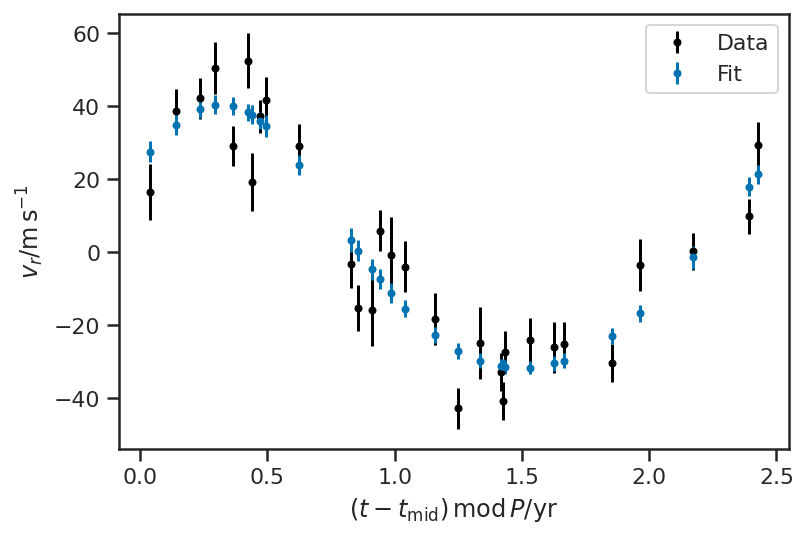

In [58]:
N = planet_trace['P'].shape[0]
i = randint(0, N)
P = planet_trace['P'][i]
plot_data(rv_obs, sigma_rv, P=P, color='black', label='Data')
plot_data(planet_trace['rv'][i,:], std(planet_trace['rv'], axis=0), P = P, label='Fit')
legend(loc='best')

We can infer that indeed, we have made a good job. However in order to be completely sure we need to check the residues. Therefore, after plotting the residues folded in one period,

<Figure size 432x288 with 0 Axes>

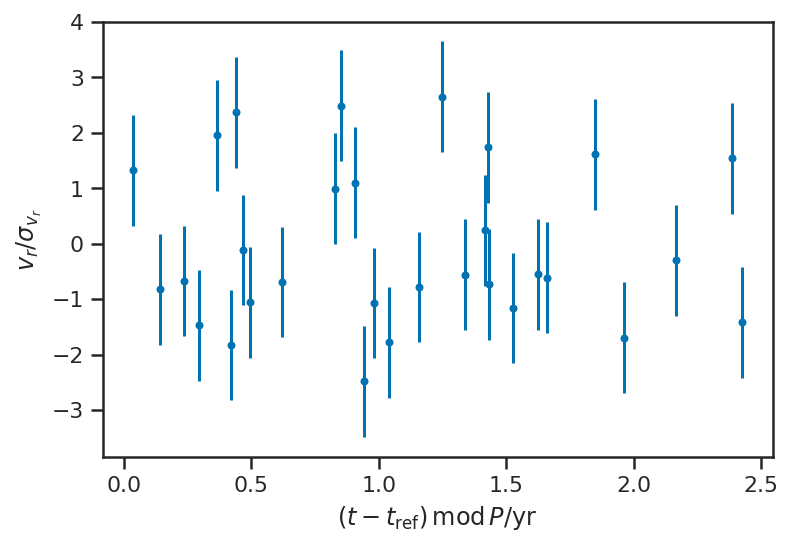

<Figure size 432x288 with 0 Axes>

In [59]:
def plot_residuals(rv, P=None, normalize=True, **kwargs):

    ts = sato_data['JD']/365.25
    tmid = median(ts)

    if P is None:
        ts = ts - tmid
        xlabel(r'$t - t_\mathrm{ref} / \mathrm{yr}$')
    else:
        ts = (ts - tmid) % P
        xlabel(r'$ \left( t - t_\mathrm{ref} \right) \, \mathrm{mod} \, P / \mathrm{yr}$')

    r = rv - sato_data['Radial_Velocity']
    if normalize:
        r = r / sato_data['Radial_Velocity_Uncertainty']
        sigma_r = ones_like(r)
    else:
        sigma_r = sato_data['Radial_Velocity_Uncertainty']
        
    fmt = kwargs.pop('fmt', '.')
    errorbar(ts, r, yerr=sigma_r, fmt=fmt, **kwargs)

plot_residuals(mean(planet_trace['rv'], axis=0), P = mean(planet_trace['P']))
ylabel(r'$v_r / \sigma_{v_r}$')
figure()

And plotting the residuals density distribution:

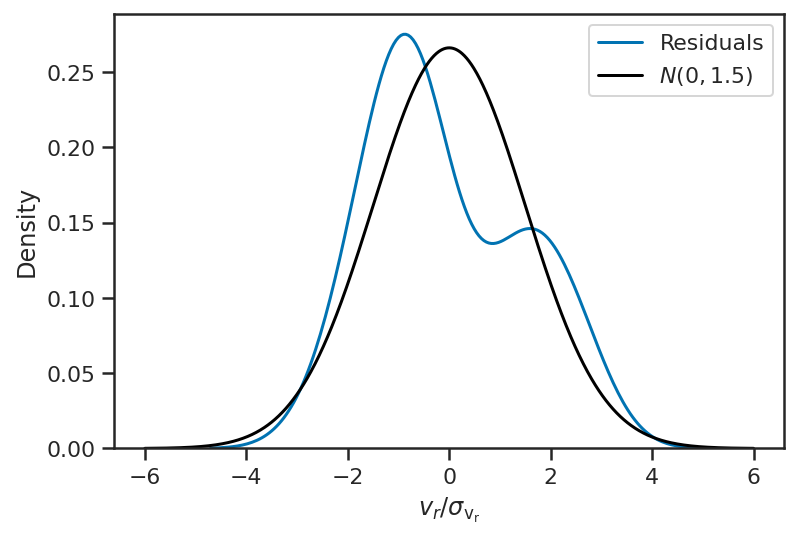

In [60]:
sns.kdeplot((mean(planet_trace['rv'], axis=0) - sato_data['Radial_Velocity'])/sato_data['Radial_Velocity_Uncertainty'], label='Residuals')
xlabel(r'$v_r / \sigma_\mathrm{v_r}$')
xs = linspace(-6, 6, 1024)
sigma = 1.5
plot(xs, 1/sqrt(2*pi*sigma**2)*exp(-0.5*xs*xs/sigma**2), color='black', label='$N(0,1.5)$')
legend(loc='best')

We can asset that our model fits with an uncertainty $\sim 1.5\sigma$ away from the data. Now we may compute the quantities of our model:

P = 2.4630^{+0.0404}_{-0.0397}


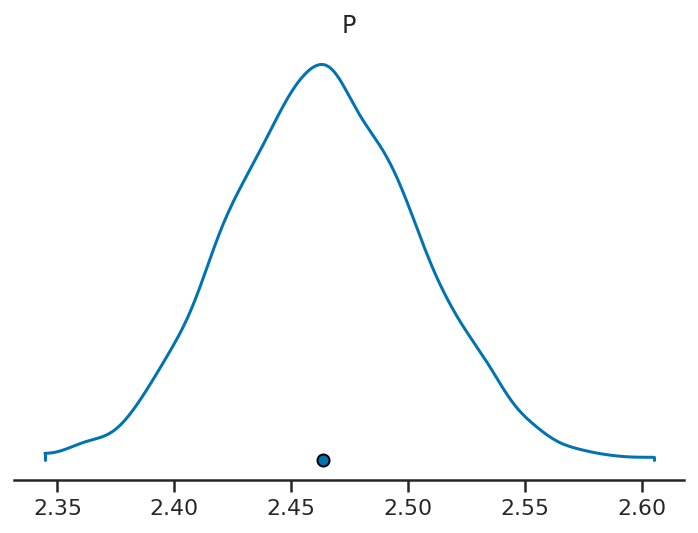

In [48]:
with planet:
    pm.plot_density(planet_trace, var_names=['P'], hdi_prob=1)
    m, l, h = quantile(planet_trace['P'], [0.5, 0.16, 0.84])
    print('P = {:.4f}^{{+{:.4f}}}_{{-{:.4f}}}'.format(m, h-m, m-l))

K = 36.1840^{+1.4702}_{-1.4749}


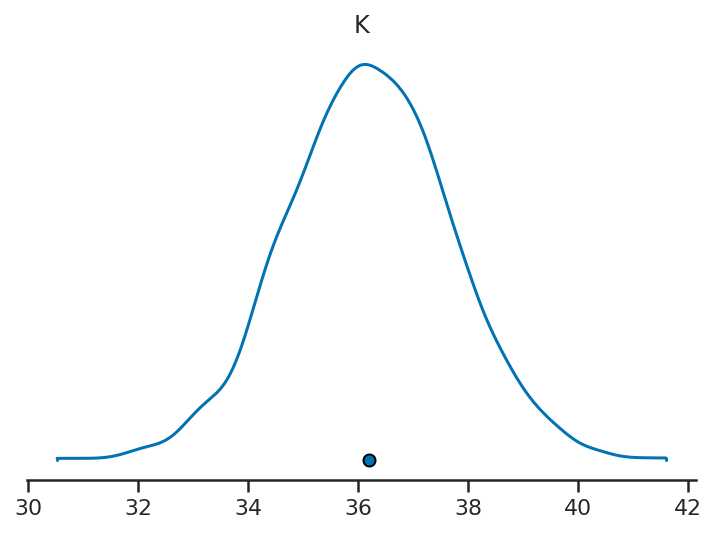

In [49]:
with planet:
    pm.plot_density(planet_trace, var_names=['K'], hdi_prob=1)
    m, l, h = quantile(planet_trace['K'], [0.5, 0.16, 0.84])
    print('K = {:.4f}^{{+{:.4f}}}_{{-{:.4f}}}'.format(m, h-m, m-l))

e = 0.1461^{+0.0422}_{-0.0421}


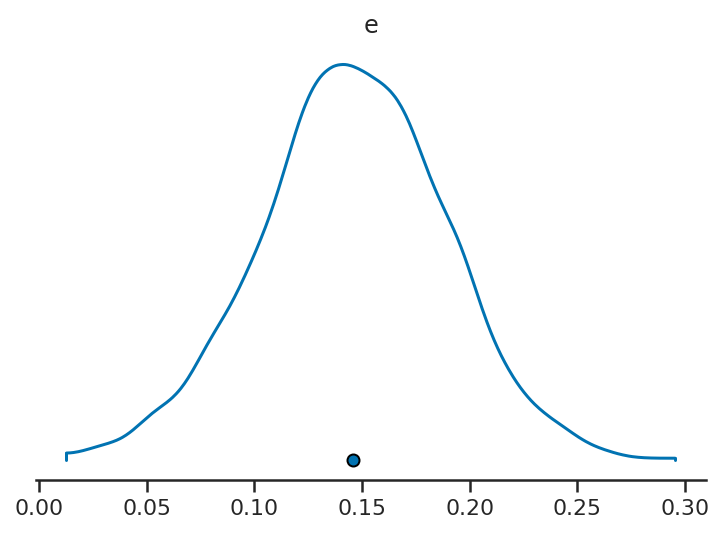

In [50]:
with planet:
    pm.plot_density(planet_trace, var_names=['e'], hdi_prob=1)
    m, l, h = quantile(planet_trace['e'], [0.5, 0.16, 0.84])
    print('e = {:.4f}^{{+{:.4f}}}_{{-{:.4f}}}'.format(m, h-m, m-l))

omega = 0.4778^{+0.4197}_{-0.3979}


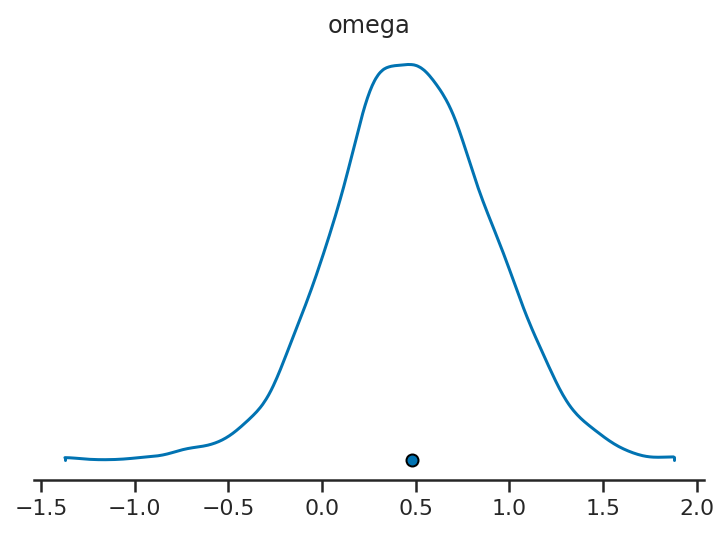

In [51]:
with planet:
    pm.plot_density(planet_trace, var_names=['omega'], hdi_prob=1)
    m, l, h = quantile(planet_trace['omega'], [0.5, 0.16, 0.84])
    print('omega = {:.4f}^{{+{:.4f}}}_{{-{:.4f}}}'.format(m, h-m, m-l))

t0 = 6719.6016^{+0.0390}_{-0.0410}


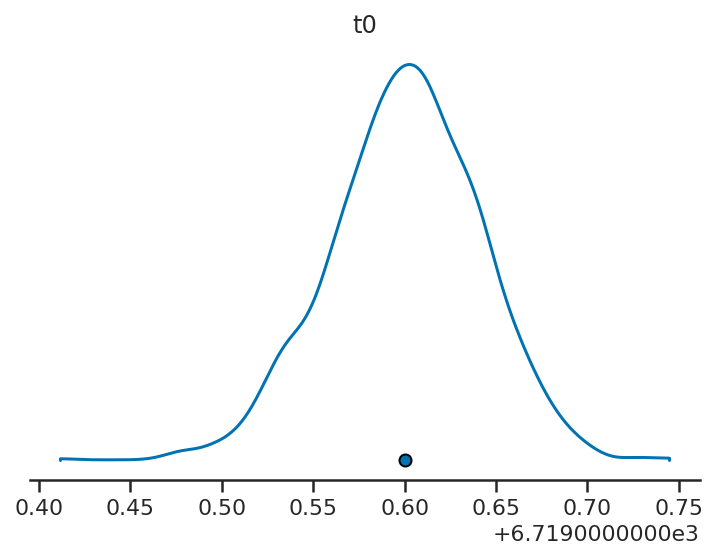

In [61]:
with planet:
    pm.plot_density(planet_trace, var_names=['t0'], hdi_prob=1)
    m, l, h = quantile(planet_trace['t0'], [0.5, 0.16, 0.84])
    print('t0 = {:.4f}^{{+{:.4f}}}_{{-{:.4f}}}'.format(m, h-m, m-l))

Now, comparing these results with the tabulated data in the catalog we see an impresive match to the observations made by Sato et. al 2008.